# Rail network exploration



## Goal
* Understand the BOF rail netwrok dataset. 
* Merge it with the intermodal data set.
* Simplify this merged dataset (remove unnecesary nodes).

In [1]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import collections

from shapely.geometry import Polygon, LineString

pd.set_option('display.max_columns', None)

## Import BOF data sets

In [2]:
shp_lines = gpd.read_file('rail_data/North_American_Rail_Lines-shp/North_American_Rail_Lines.shp')

shp_nodes = gpd.read_file('rail_data/North_American_Rail_Nodes-shp/North_American_Rail_Nodes.shp')

Source: https://data-usdot.opendata.arcgis.com/datasets/north-american-rail-lines-1

## Explore the shape files

In [3]:
shp_lines.head(2)

,OBJECTID,FRAARCID,FRFRANODE,TOFRANODE,STFIPS,CNTYFIPS,STCNTYFIPS,STATEAB,COUNTRY,FRAREGION,RROWNER1,RROWNER2,RROWNER3,TRKRGHTS1,TRKRGHTS2,TRKRGHTS3,TRKRGHTS4,TRKRGHTS5,TRKRGHTS6,TRKRGHTS7,TRKRGHTS8,TRKRGHTS9,SUBDIV,YARDNAME,PASSNGR,STRACNET,TRACKS,DIRECTION,CARDDIRECT,NET,MILES,KM,TIMEZONE,IM_RT_TYPE,DS,ShapeSTLen,geometry
0,1,300000,348741,348746,38,015,38015,ND,US,8,DMVW,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0,2.0,None,M,0.178100,0.286624,C,None,None,418.656726,"LINESTRING (-100.74520 46.80284, -100.74508 46..."
1,2,300001,338567,338686,30,087,30087,MT,US,8,BNSF,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.0,NaN,None,O,0.887103,1.427657,M,None,None,2047.011640,"LINESTRING (-106.65758 45.86404, -106.65768 45..."


In [4]:
shp_lines.describe()

,OBJECTID,FRAARCID,FRFRANODE,TOFRANODE,FRAREGION,TRACKS,DIRECTION,MILES,KM,ShapeSTLen
count,302131.000000,302131.000000,302131.000000,302131.00000,302131.000000,302124.000000,96571.000000,302131.000000,302131.000000,3.021310e+05
mean,152009.773194,488832.827128,449977.248899,449995.46592,25.435543,0.427331,1.999648,0.872242,1.403740,1.883534e+03
std,87905.284810,147244.025982,113806.040088,113780.36623,39.327784,0.608227,0.018760,3.085653,4.965888,7.957956e+03
min,1.000000,300000.000000,300000.000000,300000.00000,1.000000,0.000000,1.000000,0.000711,0.001145,1.546069e+00
25%,75533.500000,375553.500000,361490.500000,361533.50000,3.000000,0.000000,2.000000,0.083260,0.133995,1.784529e+02
50%,152693.000000,451152.000000,424314.000000,424349.00000,5.000000,0.000000,2.000000,0.236070,0.379918,5.028762e+02
75%,228225.500000,526722.500000,489578.000000,489608.50000,8.000000,1.000000,2.000000,0.649502,1.045275,1.393329e+03
max,303758.000000,902523.000000,902418.000000,902418.00000,99.000000,13.000000,2.000000,991.591668,1595.815292,2.943182e+06


<AxesSubplot:>

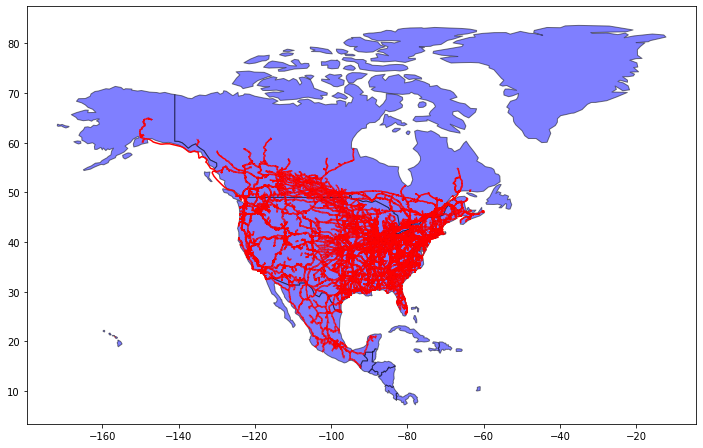

In [5]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
n_america = world[world["continent"] == "North America"]

fig, ax = plt.subplots(figsize=(12,10))
n_america.plot(ax=ax, edgecolor="black", color = "blue", alpha=0.5)
shp_lines.plot(ax=ax, color="Red")

Lets zoom in the Florida region to better understand the network 

<AxesSubplot:>

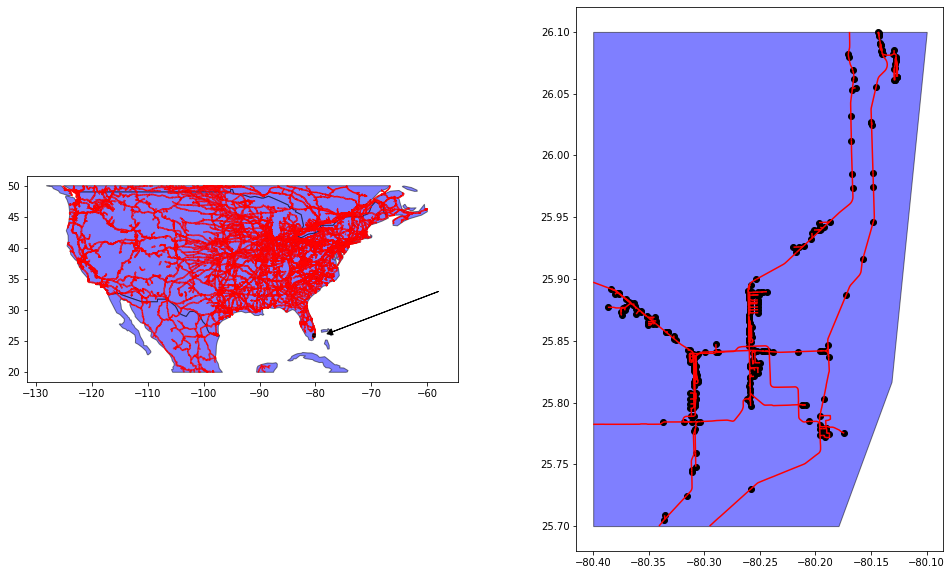

In [6]:
map_limit_poly = Polygon([(-140, 20), (-140, 50), (-60, 50), (-60, 20)])
map_limit = gpd.GeoDataFrame([1], geometry=[map_limit_poly], crs=world.crs)

fig, ax = plt.subplots(1, 2, figsize=(17,10))
n_america_clipped = gpd.clip(n_america, map_limit)
n_america_clipped.plot(ax=ax[0], edgecolor="black", color = "blue", alpha=0.5)
shp_lines_clipped = gpd.clip(shp_lines, map_limit)
shp_lines_clipped.plot(ax=ax[0], color="red")
ax[0].arrow(-58, 33, -19, -6.5, head_width=1, head_length=1, fc='k', ec='k')

poly = Polygon([(-80.4, 25.7), (-80.4, 26.1), (-80, 26.1), (-80, 25.7)])
polygon = gpd.GeoDataFrame([1], geometry=[poly], crs=world.crs)
polygon.boundary.plot(ax=ax[0], color="Black")


clipped_map = gpd.clip(n_america, polygon)
clipped_shp_lines = gpd.clip(shp_lines, polygon)
clipped_shp_nodes = gpd.clip(shp_nodes, polygon)

clipped_map.plot(ax=ax[1], edgecolor="black", color = "blue", alpha=0.5)
clipped_shp_lines.plot(ax=ax[1], color="red")
clipped_shp_nodes.plot(ax=ax[1], color="black")

### Observations
* The data set includes rail lanes in Canada and Mexico. As this project is focused on the rail network in the USA, theses lanes will be ingnored.
<br>
* There seem to be many unnecessary/abandoned lanes. They will have to be removed.
<br>
* Each lane segment is extremly short (mean 1.4 KM). The data will thus have to be cleaned to remove unnecesary nodes. 
<br>
* The dataset does not include the intermodal facilities. They will have to be fetched from another dataset.



## 1) Data filtering

In [7]:
shp_lines_relevant = shp_lines[shp_lines.eval("(NET == 'I' | NET == 'M') &  COUNTRY == 'US'")].copy()

In [8]:
shp_nodes_relevant = shp_nodes[shp_nodes.FRANODEID.isin(list(shp_lines_relevant.FRFRANODE.values) + list(shp_lines_relevant.TOFRANODE.values))]

In [9]:
def lane_filter_by_operator(shp_file, operators):
    # Filters the dataset, only keep the specified operators.
    
    mask = shp_lines.isin(operators).any(axis=1)
    filtered_shp_lines = shp_lines[mask]
    return filtered_shp_lines

## 2) Adding the intermodal facilities

In [10]:
shp_intermodal_nodes = gpd.read_file('rail_data/Intermodal stations/Intermodal_Freight_Facilities_RailTOFCCOFC.shp')

<AxesSubplot:>

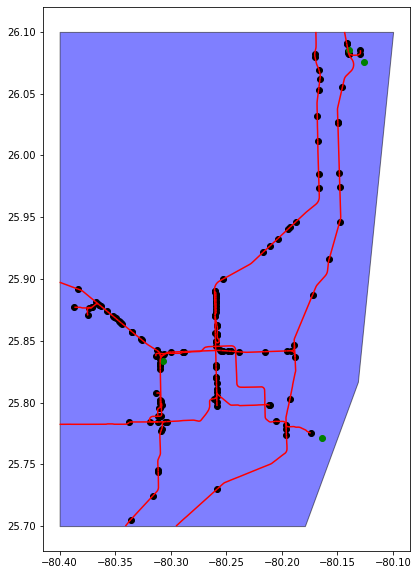

In [11]:
poly = Polygon([(-80.4, 25.7), (-80.4, 26.1), (-80, 26.1), (-80, 25.7)])
polygon = gpd.GeoDataFrame([1], geometry=[poly], crs=world.crs)

clipped_map = gpd.clip(n_america, polygon)
clipped_shp_lines_relevant = gpd.clip(shp_lines_relevant, polygon)
clipped_shp_nodes_relevant = gpd.clip(shp_nodes_relevant, polygon)
clipped_shp_nodes_intermodal = gpd.clip(shp_intermodal_nodes, polygon)

fig, ax = plt.subplots(figsize=(12,10))
clipped_map.plot(ax=ax, edgecolor="black", color = "blue", alpha=0.5)
clipped_shp_lines_relevant.plot(ax=ax, color="red")
clipped_shp_nodes_relevant.plot(ax=ax, color="black")
clipped_shp_nodes_intermodal.plot(ax=ax, color="green")

### Observations

The intermodal facilities are not located at the exact locations of the nodes. 
To by-pass this issue, the closest node to an intermodal facility will be considered as beeing an intermodal facility. 

Note that both dataset have the same CRS (EPSG:4326) thus no conversion needs to be applied.

### Create a mapping from nodes to intrmodal nodes

In [12]:
def extract_coords(row):
    row['lat'] = row['geometry'].coords[0][1]
    row['lon'] = row['geometry'].coords[0][0]
    return row

In [13]:
intermodal_nodes = shp_intermodal_nodes.copy().apply(lambda x: extract_coords(x), axis=1)
nodes = shp_nodes_relevant.copy().apply(lambda x: extract_coords(x), axis=1).set_index('FRANODEID')

In [14]:
node_idx = list()
intermodal_idx = list()

for index_i, row in intermodal_nodes.iterrows():
    d_node_to_intermodal = pd.eval('(nodes.lat-row.lat)**2 + (nodes.lon-row.lon)**2')
    intermodal_idx.append(index_i+1)
    node_idx.append(d_node_to_intermodal.idxmin())
    
intermodal_map = pd.Series(intermodal_idx,index = node_idx)    

In [15]:
intermodal_map

491145      1
338587      2
358231      3
388695      4
430934      5
         ... 
320774    177
472387    178
449719    179
493543    180
363446    181
Length: 181, dtype: int64

In [16]:
shp_nodes_relevant_w_intermodal = shp_nodes_relevant.replace(intermodal_map).copy()

shp_lines_relevant_w_intermodal = shp_lines_relevant.replace(intermodal_map).copy()

In [17]:
shp_nodes_relevant_w_intermodal.head(1)

,OBJECTID,FRANODEID,COUNTRY,STATE,STFIPS,CTYFIPS,STCYFIPS,FRAREGION,BNDRY,PASSNGR,PASSNGRSTN,geometry
0,1,300000,US,HI,15,009,15009,7,0,None,None,POINT (-156.68971 20.93653)


It can be noticed that intermodal node now have a `FRANODEID` between 1 and 181 while normal node's ID is larger than 300'000. This will be used to identify intermodal nodes.

<AxesSubplot:>

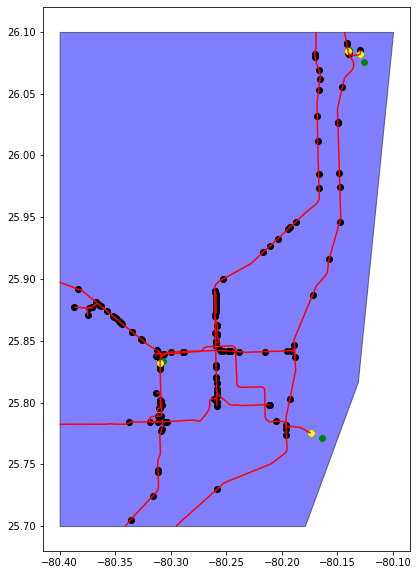

In [18]:
poly = Polygon([(-80.4, 25.7), (-80.4, 26.1), (-80, 26.1), (-80, 25.7)])
polygon = gpd.GeoDataFrame([1], geometry=[poly], crs=world.crs)

clipped_map = gpd.clip(n_america, polygon)
clipped_shp_lines_relevant = gpd.clip(shp_lines_relevant_w_intermodal, polygon)
clipped_shp_nodes_relevant = gpd.clip(shp_nodes_relevant_w_intermodal, polygon)
clipped_shp_nodes_intermodal = gpd.clip(shp_intermodal_nodes, polygon)

fig, ax = plt.subplots(figsize=(12,10))
clipped_map.plot(ax=ax, edgecolor="black", color = "blue", alpha=0.5)
clipped_shp_lines_relevant.plot(ax=ax, color="red")
clipped_shp_nodes_relevant.plot(ax=ax, color="black")
clipped_shp_nodes_intermodal.plot(ax=ax, color="green")
clipped_shp_nodes_relevant[clipped_shp_nodes_relevant.FRANODEID < 100000].plot(ax=ax, color="yellow")

It can bee seen that the approximation (yellow) of the intermodal facilities (green) by its closest node seem to be resonable.

## 3) Degree distribution 

In [19]:
def plot_get_degree_dist(links_df, table = False):
    
    G = nx.from_pandas_edgelist(links_df, source='FRFRANODE', target='TOFRANODE')
    degree_sequence = sorted([d for n, d in G.degree()], reverse=False)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.70, color="b")

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d for d in deg])
    for i, v in enumerate(cnt):
        ax.text(i+0.95, v + .9, str(v), color='blue')
    ax.set_xticklabels(deg)
    
    if table:
        print(pd.DataFrame({'deg':deg, 'cnt':cnt}))

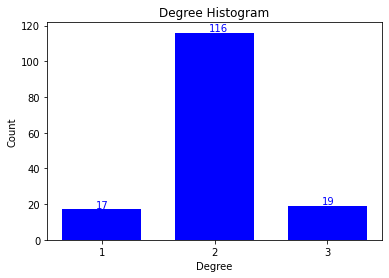

In [20]:
plot_get_degree_dist(clipped_shp_lines_relevant)

As discussed before, many nodes are unnecesary (2 degrees). A function to remove theses unnecessary nodes will be created to filter and simplify the geodataset.

In [21]:
def make_net_undirected(df):
    count = 0
    df = df.copy()
    G = nx.from_pandas_edgelist(df, source='FRFRANODE', target='TOFRANODE')
    for _from, _to in G.edges:
        if df[((df.FRFRANODE == _from) & (df.TOFRANODE == _to)) | ((df.TOFRANODE == _from) & (df.FRFRANODE == _to))].shape[0] > 1:
            df.drop(df[((df.FRFRANODE == _from) & (df.TOFRANODE == _to)) | ((df.TOFRANODE == _from) & (df.FRFRANODE == _to))].index[:-1], inplace = True)
            count += 1
    return df

In [22]:
def concat_segements_data(df,idx,idx_after):
    
    df.loc[idx,'geometry'].coords = df.loc[idx,'geometry'].coords[:] + df.loc[idx_after,'geometry'].coords[:]
    df.loc[idx,'KM'] = df.loc[idx,'KM'] + df.loc[idx_after,'KM']
    df.loc[idx,'MILES'] = df.loc[idx,'MILES'] + df.loc[idx_after,'MILES']

    
def remove_single_node(df, n1, n, n2, node_type):

    if node_type == 'linear':
        idx = df[(df.FRFRANODE == n1) & (df.TOFRANODE == n)].index[0]
        idx_after = df[(df.FRFRANODE == n) & (df.TOFRANODE == n2)].index[0]
        df.loc[idx,'TOFRANODE'] = n2
        
    elif node_type == 'sink':
        idx = df[(df.FRFRANODE == n1) & (df.TOFRANODE == n)].index[0]
        idx_after = df[(df.FRFRANODE == n2) & (df.TOFRANODE == n)].index[0] 
        df.loc[idx,'TOFRANODE'] = n2
        
    elif node_type == 'source':
        idx = df[(df.FRFRANODE == n) & (df.TOFRANODE == n1)].index[0]
        idx_after = df[(df.FRFRANODE == n) & (df.TOFRANODE == n2)].index[0] 
        df.loc[idx,'FRFRANODE'] = n2
        
    concat_segements_data(df,idx,idx_after)
    
    df.drop([idx_after],inplace = True)
    
    return df
    

def degree_two_removal(df):

    df = df.copy()
    
    G = nx.from_pandas_edgelist(df, source='FRFRANODE', target='TOFRANODE',create_using=nx.Graph())
    nodes = list(G.nodes())
    
    for n in nodes:
        if G.degree(n) == 2 and n > 100000:
            #Avoid removing intermodal nodes

            n1, n2 = G.neighbors(n)
            
            if G.has_edge(n1, n2):
                continue

            if df[(df.FRFRANODE == n)].shape[0] == 2: 
                remove_single_node(df,n1,n,n2,'source')
                G.add_edge(n2, n1)

            elif df[(df.TOFRANODE == n)].shape[0] == 2: 
                remove_single_node(df,n1,n,n2,'sink')
                G.add_edge(n2, n1)
                
            elif df[(df.FRFRANODE == n1) & (df.TOFRANODE == n)].shape[0] == 1: 
                remove_single_node(df,n1,n,n2,'linear')
                G.add_edge(n1, n2)

            elif df[(df.FRFRANODE == n2) & (df.TOFRANODE == n)].shape[0] == 1: 
                remove_single_node(df,n2,n,n1,'linear')
                G.add_edge(n2, n1)
            
            G.remove_node(n)

    return df

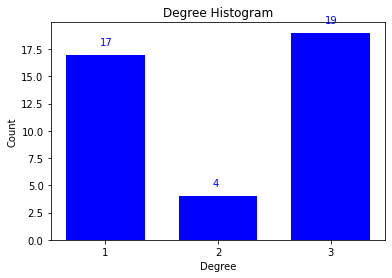

In [23]:
clipped_shp_lines_relevant_undirected = make_net_undirected(clipped_shp_lines_relevant)

clipped_shp_lines_relevant_undirected_filtered = degree_two_removal(clipped_shp_lines_relevant_undirected)

plot_get_degree_dist(clipped_shp_lines_relevant_undirected_filtered)

It can be seen that the filtering function seem to work well as only degree two nodes (which are not intermodal) have been removed.

<AxesSubplot:>

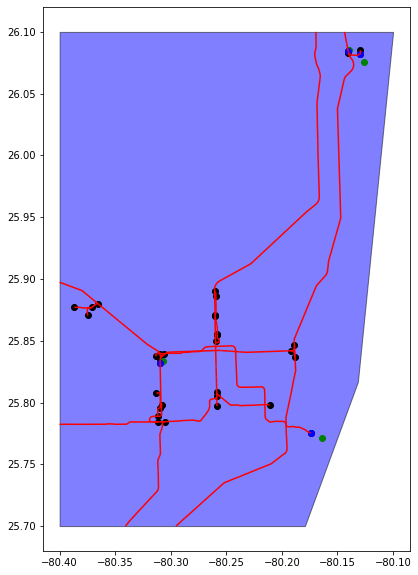

In [24]:
shp_nodes_relevant_cleaned_red = clipped_shp_nodes_relevant[clipped_shp_nodes_relevant.FRANODEID.isin(clipped_shp_lines_relevant_undirected_filtered.FRFRANODE.values) | clipped_shp_nodes_relevant.FRANODEID.isin(clipped_shp_lines_relevant_undirected_filtered.TOFRANODE.values)]

clipped_map = gpd.clip(n_america, polygon)
clipped_shp_lines_relevant = gpd.clip(shp_lines_relevant, polygon)
clipped_shp_nodes_relevant = gpd.clip(shp_nodes_relevant_cleaned_red, polygon)
clipped_shp_nodes_intermodal = gpd.clip(shp_intermodal_nodes, polygon)

fig, ax = plt.subplots(figsize=(12,10))
clipped_map.plot(ax=ax, edgecolor="black", color = "blue", alpha=0.5)
clipped_shp_lines_relevant.plot(ax=ax, color="red")
shp_nodes_relevant_cleaned_red.plot(ax=ax, color="black")
clipped_shp_nodes_intermodal.plot(ax=ax, color="green")
clipped_shp_nodes_relevant[clipped_shp_nodes_relevant.FRANODEID < 100000].plot(ax=ax, color="blue")

The next cell is commented as this operation takes a lot of time (about 2.5 hours), the file has already been generated and can be loaded from the repository.

In [25]:
# shp_lines_relevant_w_intermodal = shp_lines_relevant.replace(intermodal_map).copy()

# shp_lines_relevant_w_intermodal_undirected = make_net_undirected(shp_lines_relevant_w_intermodal)

# shp_lines_relevant_w_intermodal_undirected_filtered = degree_two_removal(shp_lines_relevant_w_intermodal_undirected)

# shp_lines_relevant_w_intermodal_undirected_filtered.to_file("rail_data/cleaned_data/rail_lines_cleaned/shp_lines_relevant_cleaned.shp")

In [26]:
shp_lines_relevant_cleaned = gpd.read_file("rail_data/cleaned_data/rail_lines_cleaned/shp_lines_relevant_cleaned.shp")

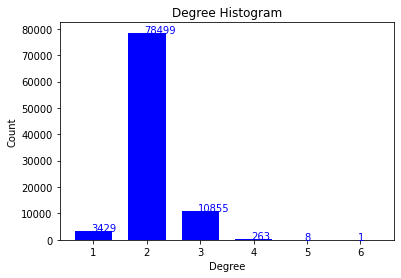

In [27]:
plot_get_degree_dist(shp_lines_relevant_w_intermodal)

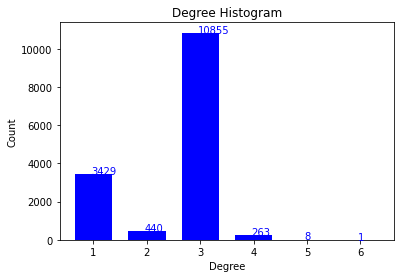

In [28]:
plot_get_degree_dist(shp_lines_relevant_cleaned)

Again one can observe that the filtering of the data seems correct as only nodes with degree two (excluding intermodal nodes) have been removed.

In [29]:
# shp_nodes_relevant_cleaned = shp_nodes_relevant_w_intermodal[shp_nodes_relevant_w_intermodal.FRANODEID.isin(shp_lines_relevant_cleaned.FRFRANODE.values) | shp_nodes_relevant_w_intermodal.FRANODEID.isin(shp_lines_relevant_cleaned.TOFRANODE.values)]
# shp_nodes_relevant_cleaned.to_file("rail_data/cleaned_data/rail_nodes_cleaned/shp_nodes_relevant_cleaned.shp")

In [30]:
shp_nodes_relevant_cleaned = gpd.read_file("rail_data/cleaned_data/rail_nodes_cleaned/shp_nodes_relevant_cleaned.shp")

The whole data set has now been cleaned.